# Machine Learning and Data Analysis

### Developed by Jerin Joy and Koushikmani Maskalmatti Lakshman under the guidance of Prof. Luca Oneto.

### Project - Obstacle avoidance using Machine Learning algorithm in ROS.

Description of the Project:
The Turtlebot robot is a popular platform for robotics research and education. With its sensors, cameras, and actuators, it provides a great platform for testing and developing algorithms for robot navigation and control. One of the key challenges in robotics is obstacle avoidance, which involves navigating in an environment with unknown obstacles and avoiding collisions. This project aims to address this challenge by using machine learning algorithms to train the Turtlebot robot to avoid obstacles.

To implement obstacle avoidance, we start by collecting data using the Turtlebot's laser range finder. This sensor measures the distance to obstacles in the environment and provides a 2D scan of the surroundings. We use this data to train various machine learning classifiers such as neural networks, random forest, KNN, and decision trees. These classifiers learn to classify the environment into obstacle and non-obstacle regions based on the laser scan data. Once the classifiers are trained, we use them to implement obstacle avoidance in the Turtlebot robot. This allows the robot to navigate autonomously in an unknown environment, avoiding obstacles in its path. By using machine learning, we can create intelligent robots that can adapt to different environments and tasks, making them more useful and versatile.

## Headers
Headers that are used in the entire package are given below.

In [100]:
%%capture

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, validation_curve, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.python.keras.metrics import Accuracy, Precision, Recall, AUC, CategoricalAccuracy

This code reads data from a CSV file named "data.csv" and replaces all infinite values with 3.5. The data contains 120 features with column names starting with "x_" and two additional columns named "v" and "w".

After reading the data, some data cleaning operations are performed. Values of "v" and "w" columns are modified such that if "v" has a value of 0.3, it is replaced with 1 and if "w" has a value of 0.3, it is replaced with 1. Conversely, if "v" has a value of 0.3, the corresponding "w" value is set to 0, and if "w" has a value of 0.3, the corresponding "v" value is set to 0.

In [3]:
# Read Data
columns = []
for i in range(120):
    columns.append(f'x_{i}')

columns = columns + ['v', 'w']

df = pd.read_csv('data.csv')
df.replace([np.inf], 3.5, inplace=True)

df.columns = columns
df.loc[df['v'] == 0.3, "v"] = 1
df.loc[df['v'] == 0.3, "w"] = 0
df.loc[df['w'] == 0.3, "v"] = 0
df.loc[df['w'] == 0.3, "w"] = 1

print("Raw Data")
print(df.head(5))
print(f"Number of Data Entries: {len(df)}")
print(f"Number of v Entries: {len(df[df['v'] == 1])}")
print(f"Number of w Entries: {len(df[df['w'] == 1])}")

Raw Data
        x_0       x_1       x_2       x_3       x_4       x_5       x_6  \
0  1.757790  1.756795  1.747663  1.767158  1.765271  1.779900  1.762095   
1  1.748229  1.764128  1.739702  1.747016  1.753816  1.740524  1.761002   
2  1.715352  1.709566  1.709361  1.717771  1.728112  1.720871  1.724907   
3  1.670870  1.674756  1.662285  1.673070  1.666844  1.656339  1.689519   
4  1.617006  1.601120  1.595978  1.622197  1.605366  1.617249  1.617327   

        x_7       x_8       x_9  ...     x_112     x_113     x_114     x_115  \
0  1.772469  1.754512  1.766275  ...  1.790406  1.763388  1.749376  1.749038   
1  1.769007  1.759623  1.780307  ...  1.745286  1.774112  1.745656  1.754775   
2  1.712213  1.739454  1.727565  ...  1.719604  1.711219  1.714881  1.732098   
3  1.667948  1.683522  1.694583  ...  1.672852  1.687144  1.668343  1.683015   
4  1.624864  1.617897  1.622327  ...  1.615128  1.621961  1.622301  1.580144   

      x_116     x_117     x_118     x_119    v    w  
0  1.

In [4]:
# Split into features and labels
X = df.drop(['v', 'w'], axis=1)
y = df[['v', 'w']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print("Prepared Data")
print("y_train Dataframe\n")
print(y_train.head(5))

print("X_train Dataframe\n")
print(X_train.head(5))


Prepared Data
y_train Dataframe

         v    w
43863  0.0  1.0
67351  0.0  1.0
55481  1.0  0.0
10724  0.0  1.0
57773  1.0  0.0
X_train Dataframe

            x_0       x_1       x_2       x_3       x_4       x_5       x_6  \
43863  2.441709  2.483620  2.541319  2.588968  2.638444  2.678917  2.739196   
67351  1.774071  2.015963  2.386438  2.916492  3.418988  3.408353  3.426925   
55481  0.425189  0.415537  0.424897  0.406838  0.397739  0.410233  0.378173   
10724  3.500000  3.500000  3.500000  2.539820  2.521772  2.551445  3.500000   
57773  3.306483  3.205808  3.119955  3.023582  2.953182  1.261921  1.209744   

            x_7       x_8       x_9  ...     x_110     x_111     x_112  \
43863  2.807427  2.856613  2.929956  ...  2.140733  2.176810  2.217819   
67351  3.399066  3.416911  3.429713  ...  0.805999  0.863443  0.941659   
55481  0.380399  0.380356  0.391224  ...  0.488518  0.476274  0.461388   
10724  3.500000  3.500000  3.500000  ...  3.280444  3.298074  1.332962   
57773  

### Classifiers used in the project

1. Decision Tree Classifier
2. Random Forest Classifier
3. K-Nearest Neighbors Classifier
4. Tensorflow Neural Network Classifier

In [118]:
# Decision Tree Classifier
dt_model = DecisionTreeClassifier()

# Random Forest Classifier
rf_model = RandomForestClassifier()

# K-Nearest Neighbors Classifier
knn_model = KNeighborsClassifier()

# Tensorflow Neural Network Classifier
nn_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']);

This code section defines a function called "evaluate_model" that takes in three parameters: a machine learning model, training data (X_train), and target data (y_train). The function uses k-fold cross-validation to evaluate the performance of the machine learning model on the training data. It splits the data into k folds, fits the model on k-1 folds, and evaluates the model on the remaining fold. This process is repeated for each of the k folds. The function returns the mean accuracy, precision, recall, ROC AUC, and F1 scores across all folds, as well as the confusion matrix for each fold. The function can handle both scikit-learn and TensorFlow Keras models, but uses different methods to compute scores and confusion matrices depending on the type of model.

In [120]:
# Define a function to evaluate a model using cross-validation and k-fold
def evaluate_model(model, X_train, y_train):
    # Define number of folds
    k = 5
    
    # Create a KFold object
    kf = KFold(n_splits=k)
    
    # Initialize lists to store scores for each fold
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    roc_auc_scores = []
    f1_scores = []
    cm_list = []
    
    # Loop over each fold
    for train_index, test_index in kf.split(X_train):
        # Split data into train and test sets for this fold
        X_train_fold = X_train.iloc[train_index]
        y_train_fold = y_train.iloc[train_index]
        X_test_fold = X_train.iloc[test_index]
        y_test_fold = y_train.iloc[test_index]
        
        # Convert data into tensors if model is TensorFlow Keras model
        if isinstance(model, tf.keras.models.Sequential):
            X_train_fold = tf.convert_to_tensor(X_train_fold)
            y_train_fold = tf.convert_to_tensor(y_train_fold)
            X_test_fold = tf.convert_to_tensor(X_test_fold)
            y_test_fold = tf.convert_to_tensor(y_test_fold)
        
        # Fit model on train set
        model.fit(X_train_fold,y_train_fold)
        
        # Predict on test set
        y_pred_fold = model.predict(X_test_fold)
        
        # Compute scores for this fold if model is TensorFlow Keras model
        if isinstance(model, tf.keras.models.Sequential):
            nn_accuracy = tf.keras.metrics.CategoricalAccuracy()(y_test_fold, y_pred_fold)
            nn_precision = tf.keras.metrics.Precision()(y_test_fold, y_pred_fold)
            nn_recall = tf.keras.metrics.Recall()(y_test_fold, y_pred_fold)
            nn_roc = tf.keras.metrics.AUC()(y_test_fold, y_pred_fold)
            nn_f1 = 2 * ((nn_precision * nn_recall) / (nn_precision + nn_recall + 1e-10))
            accuracy_scores.append(nn_accuracy)
            precision_scores.append(nn_precision)
            recall_scores.append(nn_recall)
            roc_auc_scores.append(nn_roc)
            f1_scores.append(nn_f1)
            
            # Compute confusion matrix for this fold if model is TensorFlow Keras model  
            y_pred_classes = tf.argmax(y_pred_fold, axis=1)
            y_test_classes = tf.argmax(y_test_fold, axis=1)
            cm = tf.math.confusion_matrix(y_test_classes, y_pred_classes)  
            cm_list.append(np.array(cm, dtype=int))
            continue
            
        # Compute scores for this fold
        accuracy_scores.append(accuracy_score(y_test_fold,y_pred_fold))
        precision_scores.append(precision_score(y_test_fold,y_pred_fold, average = 'weighted'))
        recall_scores.append(recall_score(y_test_fold,y_pred_fold, average = 'weighted'))
        roc_auc_scores.append(roc_auc_score(y_test_fold,y_pred_fold, average = 'weighted'))
        f1_scores.append(f1_score(y_test_fold,y_pred_fold, average = 'weighted'))
        
        # Compute confusion matrix for this fold   
        cm = confusion_matrix(y_test_fold.values.argmax(axis=1),y_pred_fold.argmax(axis=1))   
        cm_list.append(cm) 
    
    # Return the mean scores across all folds
    return np.mean(accuracy_scores), np.mean(precision_scores), np.mean(recall_scores), np.mean(roc_auc_scores), np.mean(f1_scores), cm_list

In [121]:
# Evaluate each model using cross-validation and k-fold
dt_accuracy, dt_precision, dt_recall, dt_roc_auc, dt_f1, dt_cm = evaluate_model(dt_model,X,y)
rf_accuracy, rf_precision, rf_recall, rf_roc_auc, rf_f1, rf_cm = evaluate_model(rf_model,X,y)
knn_accuracy, knn_precision, knn_recall, knn_roc_auc, knn_f1, knn_cm = evaluate_model(knn_model,X,y)
nn_accuracy, nn_precision, nn_recall, nn_roc_auc, nn_f1, nn_cm = evaluate_model(nn_model,X,y)

475/475 [==============================] - 1s 1ms/step


In [122]:
# Open a file in write mode
f = open('results.txt', 'w')

# Print the results to the file
print("Decision Tree: Accuracy: {}, Precision: {}, Recall: {}, ROC AUC: {}, F1: {}".format(dt_accuracy,
                                                                                           dt_precision,
                                                                                           dt_recall,
                                                                                           dt_roc_auc,
                                                                                           dt_f1), file=f)

print("Random Forest: Accuracy: {}, Precision: {}, Recall: {}, ROC AUC: {}, F1: {}".format(rf_accuracy,
                                                                                           rf_precision,
                                                                                           rf_recall,
                                                                                           rf_roc_auc,
                                                                                           rf_f1), file=f)

print("KNN: Accuracy: {}, Precision: {}, Recall: {}, ROC AUC: {}, F1: {}".format(knn_accuracy,
                                                                                 knn_precision,
                                                                                 knn_recall,
                                                                                 knn_roc_auc,
                                                                                 knn_f1), file=f)

print("Neural Network: Accuracy: {}, Precision: {}, Recall: {}, ROC AUC: {}, F1: {}".format(nn_accuracy,
                                                                                            nn_precision,
                                                                                            nn_recall,
                                                                                            nn_roc_auc,
                                                                                            nn_f1), file=f)
# Close the file

f.close()

Plots the comparison charts for Accuracy, Precision, Recall, F1 Score and ROC-AUC of the four classifiers.

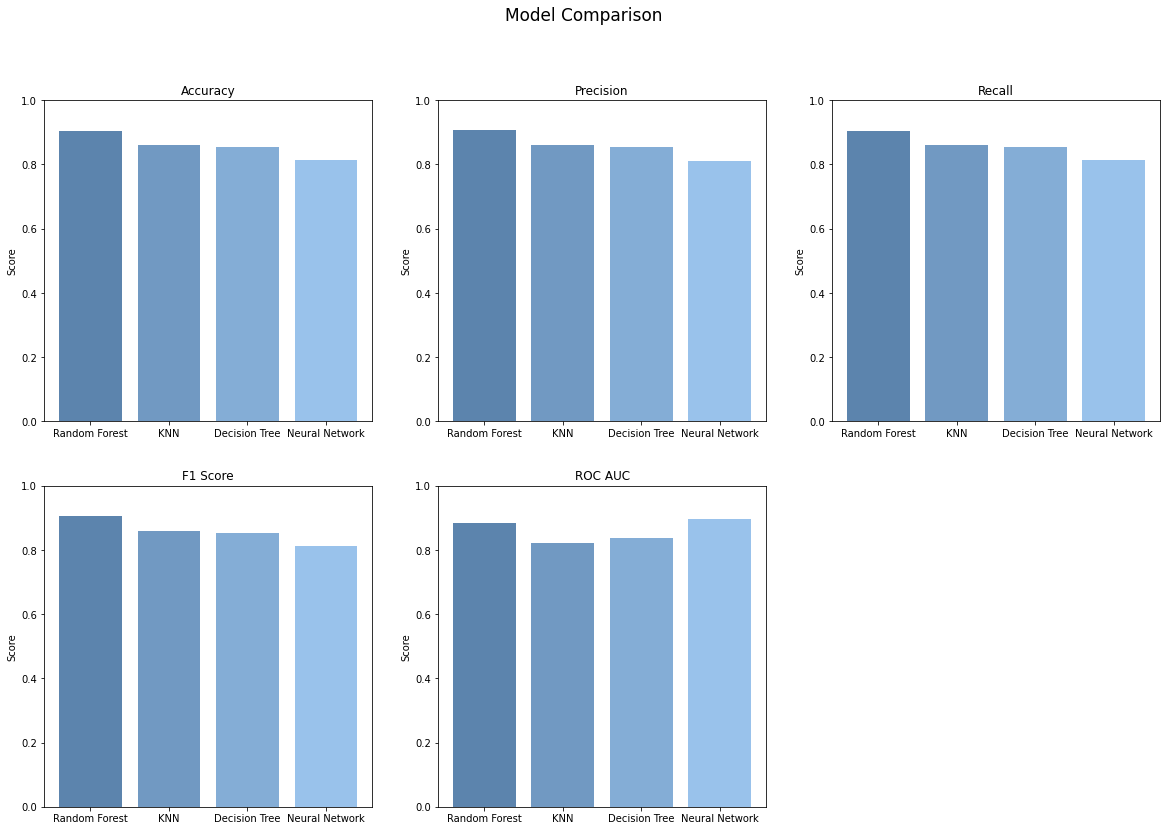

In [123]:
# Define model names and corresponding metrics
model_names = ['Random Forest', 'KNN', 'Decision Tree', 'Neural Network']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']

# Define scores for each model and metric
accuracy_scores = [rf_accuracy, knn_accuracy, dt_accuracy, nn_accuracy]
precision_scores = [rf_precision, knn_precision, dt_precision, nn_precision]
recall_scores = [rf_recall, knn_recall, dt_recall, nn_recall]
f1_scores = [rf_f1, knn_f1, dt_f1, nn_f1]
roc_auc_scores = [rf_roc_auc, knn_roc_auc, dt_roc_auc, nn_roc_auc]

# Define colors for each metric
colors = [(0.2, 0.4, 0.6, 0.8), (0.3, 0.5, 0.7, 0.8), (0.4, 0.6, 0.8, 0.8), (0.5, 0.7, 0.9, 0.8)]

# Define a list of lists for the scores
scores = [accuracy_scores, precision_scores, recall_scores, f1_scores, roc_auc_scores]

# Create a figure with 5 subplots arranged in 2 rows and 3 columns
fig = plt.figure(figsize=(20 ,13))
fig.suptitle('Model Comparison', size = '17')

# Generate plots for each metric
for i ,metric in enumerate(metrics):
    # Get the scores for the current metric
    metric_scores = scores[i]

    # Calculate the average score for each model
    model_scores = [np.mean(metric_scores[j::len(model_names)]) for j in range(len(model_names))]

    # Create a subplot for each metric
    ax = fig.add_subplot(2 ,3 ,i + 1)
    ax.bar(model_names ,model_scores ,color=colors)
    ax.set_ylim(0 ,1)
    ax.set_title(metric)
    ax.set_ylabel('Score')

Plots the Mean Confusion Matrix for the four classifiers.

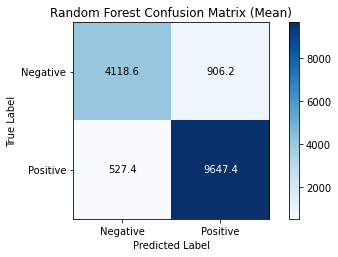

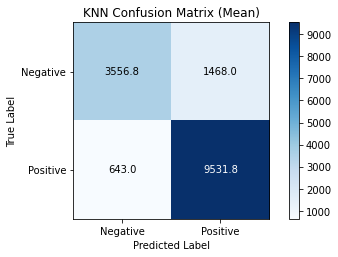

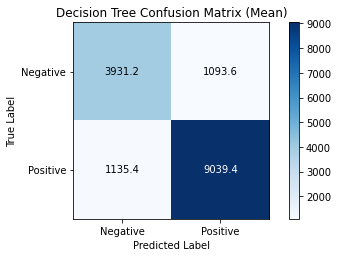

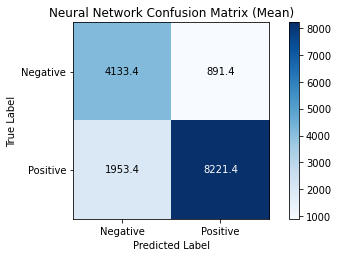

In [124]:
def plot_confusion_matrix(conf_matrices, model_name):
    n_classes = 2
    # Compute the mean confusion matrix
    mean_cm = np.mean(conf_matrices, axis=0)

    # Plot the mean confusion matrix with values
    fig, ax = plt.subplots()
    im = ax.imshow(mean_cm, cmap=plt.cm.Blues)
    ax.set_title(f'{model_name} Confusion Matrix (Mean)')
    plt.colorbar(im)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Negative', 'Positive'])
    ax.set_yticklabels(['Negative', 'Positive'])

    # Display the mean values in each grid
    for i in range(n_classes):
        for j in range(n_classes):
            # Set text color based on background brightness
            brightness = np.mean(im.cmap(im.norm([mean_cm[i, j]])))
            text_color = 'white' if brightness < 0.5 else 'black' # Check brightness of the cell color
            text = ax.text(j, i, mean_cm[i, j], ha='center', va='center', color=text_color)

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.savefig(f'confusion_matrix_{model_name.lower().replace(" ", "_")}_mean.png')
    plt.show()


    


# Plot the mean confusion matrix for the models.
plot_confusion_matrix(rf_cm, "Random Forest")
plot_confusion_matrix(knn_cm, "KNN")
plot_confusion_matrix(dt_cm, "Decision Tree")
plot_confusion_matrix(nn_cm, "Neural Network")
